In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import sklearn
from sklearn import metrics
import os
import pandas as pd
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import logging
logging.disable(30)
from collections import  Counter
import math
import random
from fitter import Fitter
random_seed =3407
random.seed(random_seed )
tf.random.set_seed(random_seed )
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
# VDR distribution alignment metric
def mix_student_vdr2(X, Y, sigmas=(1,), wts=None, biased=True):
    K_XX, K_XY, K_YY, d = _mix_student_kernel(X, Y, sigmas, wts)
    return _vdr2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)

def _mix_student_kernel(X, Y, sigmas, wts=None):
    if wts is None:
        wts = [1] * len(sigmas)

    XX = tf.matmul(X, X, transpose_b=True)
    XY = tf.matmul(X, Y, transpose_b=True)
    YY = tf.matmul(Y, Y, transpose_b=True)

    X_sqnorms = tf.linalg.diag_part(XX)
    Y_sqnorms = tf.linalg.diag_part(YY)

    r = lambda x: tf.expand_dims(x, 0)
    c = lambda x: tf.expand_dims(x, 1)

    K_XX, K_XY, K_YY = 0, 0, 0
    for sigma, wt in zip(sigmas, wts):
        gamma = math.gamma((sigma+1)/2) / (math.gamma((sigma)/2)*(sigma**0.5))                            
        K_XX += wt * gamma * tf.pow((1.+(-2 * XX + c(X_sqnorms) + r(X_sqnorms))/2.),-(sigma+1.)/2)
        K_XY += wt * gamma * tf.pow((1.+(-2 * XY + c(X_sqnorms) + r(Y_sqnorms))/2.),-(sigma+1.)/2)
        K_YY += wt * gamma * tf.pow((1.+(-2 * YY + c(Y_sqnorms) + r(Y_sqnorms))/2.),-(sigma+1.)/2)
    
    return K_XX, K_XY, K_YY, tf.reduce_sum(wts)
    

def _vdr2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = tf.cast(K_XX.get_shape()[0], tf.float32)
    n = tf.cast(K_YY.get_shape()[0], tf.float32)
    
    CM_m=tf.eye(m,m)-(1/m)*tf.ones((m,m))
    CM_n=tf.eye(n,n)-(1/n)*tf.ones((n,n))
    
    
    C_K_XX=tf.pow(tf.matmul(tf.matmul(CM_m,K_XX),CM_m, transpose_b=True),2)
    C_K_YY=tf.pow(tf.matmul(tf.matmul(CM_n,K_YY),CM_n, transpose_b=True),2)
    C_K_XY=tf.pow(tf.matmul(tf.matmul(CM_m,K_XY),CM_n, transpose_b=True),2)
    

    if biased:
        vdr2 = (tf.reduce_sum(C_K_XX) / (m * m)
              + tf.reduce_sum(C_K_YY) / (n * n)
              - 2 * tf.reduce_sum(C_K_XY) / (m * n))
    
    else:
        if const_diagonal is not False:
            trace_X = m * const_diagonal
            trace_Y = n * const_diagonal
        else:
            trace_X = tf.linalg.trace(C_K_XX)
            trace_Y = tf.linalg.trace(C_K_YY)

        vdr2 = ((tf.reduce_sum(C_K_XX) - trace_X) / ((m-1) * (m - 2))
              + (tf.reduce_sum(C_K_YY) - trace_Y) / ((n-1) * (n - 2))
              - 2 * tf.reduce_sum(C_K_XY) / ((m-1) * (n-1)))
    return vdr2

In [3]:
data1=np.load(r"Dataset\cwrudata\48kcwru_data.npy")
label1=np.load(r"Dataset\cwrudata\48kcwru_label.npy")

data2 =np.load(r"Dataset\jnudata\jnudata1000_data.npy")
label2 =np.load(r"Dataset\jnudata\jnudata1000_label.npy")

data3 =np.load(r"Dataset\seudata\seu2_data.npy")
label3 =np.load(r"Dataset\seudata\seu2_label.npy")

source_data=data1
source_label=label1

target_data=data2
target_label=label2

source_data.shape,source_label.shape,target_data.shape,target_label.shape

((4000, 3072), (4000, 4), (4000, 3072), (4000, 4))

In [4]:
source_data=(source_data-source_data.min(axis=1).reshape((len(source_data),1)))/(source_data.max(axis=1).reshape((len(source_data),1))-source_data.min(axis=1).reshape((len(source_data),1)))
target_data=(target_data-target_data.min(axis=1).reshape((len(target_data),1)))/(target_data.max(axis=1).reshape((len(target_data),1))-target_data.min(axis=1).reshape((len(target_data),1)))

In [5]:
source_data=tf.expand_dims(source_data,axis=-1)
target_data=tf.expand_dims(target_data,axis=-1)

In [6]:
train_dataset=tf.data.Dataset.from_tensor_slices((source_data,target_data,source_label,target_label))
train_dataset=train_dataset.shuffle(50000).batch(128,drop_remainder=True)

test_dataset=tf.data.Dataset.from_tensor_slices((target_data,target_label))
test_dataset=test_dataset.shuffle(50000).batch(4000,drop_remainder=True)

pre_train_dataset=tf.data.Dataset.from_tensor_slices((source_data,source_label))
pre_train_dataset=pre_train_dataset.shuffle(50000).batch(1000,drop_remainder=True)

In [7]:
test_dataset=tf.data.Dataset.from_tensor_slices((source_data,target_data,source_label,target_label))
test_dataset=test_dataset.batch(4000,drop_remainder=True)

In [8]:
input_1=tf.keras.Input(shape=(3072,1),name='source_data')

x=tf.keras.layers.Conv1D(filters=16,kernel_size=64,strides=16,activation='relu',padding='same',name='conv1')(input_1)
x=tf.keras.layers.BatchNormalization(name='bn1')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool1')(x)

x=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu',padding='same',name='conv2')(x)
x=tf.keras.layers.BatchNormalization(name='bn2')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool2')(x)

x=tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same',name='conv3')(x)
x=tf.keras.layers.BatchNormalization(name='bn3')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool3')(x)

x=tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,activation='relu',padding='same',name='conv4')(x)
x=tf.keras.layers.BatchNormalization(name='bn4')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool4')(x)

x=tf.keras.layers.Conv1D(filters=256,kernel_size=3,strides=1,activation='relu',padding='same',name='conv5')(x)
x=tf.keras.layers.BatchNormalization(name='bn5')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool5')(x)

x=tf.keras.layers.GlobalAveragePooling1D()(x)

y1=tf.keras.layers.Dense(128,activation='relu',name='cl_1')(x)
y2=tf.keras.layers.Dense(4,name='cl_2')(y1)

model=tf.keras.Model(inputs=input_1,outputs=[y1,y2])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
source_data (InputLayer)     [(None, 3072, 1)]         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 192, 16)           1040      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 16)           64        
_________________________________________________________________
plool1 (MaxPooling1D)        (None, 96, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 96, 32)            1568      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 96, 32)            128       
_________________________________________________________________
plool2 (MaxPooling1D)        (None, 48, 32)            0     

In [9]:
pre_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)               
loss_func=tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

In [10]:
'''
It should be noted that Student kernel is only proofed to statisfied the kernel property 
when the degree of freedom (DOF) is positive integer in this paper; 
however, experimental results show that the DOF corresponding to the optimal diagnostic accuracy is usually in the range of (0:1),
which needs to be further theoretical analysis in future works.
'''
# Biased VDR loss
def vdr_student_loss(X1,X2, DOF=[0.6]):
    loss = mix_student_vdr2(X1,X2, sigmas=DOF)
    return loss

In [11]:
clc_loss=tf.keras.metrics.Mean('clc_loss')                                  
mvd_loss=tf.keras.metrics.Mean('mvd_loss')
pre_train_loss=tf.keras.metrics.Mean("pre_train_loss")

train_accuracy=tf.keras.metrics.CategoricalAccuracy('train_accuracy')
pre_train_accuracy=tf.keras.metrics.CategoricalAccuracy('pre_train_accuracy')
test_accuracy=tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_acc=[]
test_acc=[]
clc_loss_=[]
mvd_loss_=[]

pre_train_acc=[]
pre_train_loss_=[]

In [12]:
def train_step(model, source_data,target_data,source_label,target_label):
    #The trade-off parameters (u,k) needs to be readjusted for different transfer diagnosis tasks.
    #u,k=100,0.2
    u,k=100,0.3
    with tf.GradientTape() as t:
        out1,output1 = model(source_data,training = True)                                
        out2,output2 = model(target_data,training = True)                                
        loss_step =u*vdr_student_loss(output1,output2)+k*loss_func(source_label,output1)     
    grads = t.gradient(loss_step, model.trainable_variables)
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    mvd_loss(u*vdr_student_loss(output1,output2))
    clc_loss(k*loss_func(source_label,output1))
    train_accuracy(source_label,output1)
    test_accuracy(target_label,output2)

    
def train():
    for epoch in range(100):
        for (batch, (source_data,target_data,source_label,target_label)) in enumerate(train_dataset):
            train_step(model,source_data,target_data,source_label,target_label)
        train_acc.append(train_accuracy.result())
        mvd_loss_.append(mvd_loss.result())
        clc_loss_.append(clc_loss.result())
        test_acc.append(test_accuracy.result())
        
        print('Epoch{}, mvd_loss is {:.5f}, clc_loss is {:.5f}, train_accuracy is {:.5f},test_accuracy is {:.5f}'.format(epoch+1,
                                                                                          mvd_loss.result(),
                                                                                          clc_loss.result(),           
                                                                                          train_accuracy.result(),
                                                                                          test_accuracy.result()))
        
        mvd_loss.reset_states()
        clc_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()

In [13]:
train()

Epoch1, mvd_loss is 0.28189, clc_loss is 0.16981, train_accuracy is 0.70917,test_accuracy is 0.44607
Epoch2, mvd_loss is 0.15431, clc_loss is 0.16745, train_accuracy is 0.77419,test_accuracy is 0.48135
Epoch3, mvd_loss is 0.11382, clc_loss is 0.17671, train_accuracy is 0.77823,test_accuracy is 0.49496
Epoch4, mvd_loss is 0.09632, clc_loss is 0.14741, train_accuracy is 0.88861,test_accuracy is 0.57384
Epoch5, mvd_loss is 0.09065, clc_loss is 0.13844, train_accuracy is 0.91280,test_accuracy is 0.66935
Epoch6, mvd_loss is 0.08591, clc_loss is 0.14405, train_accuracy is 0.87525,test_accuracy is 0.62046
Epoch7, mvd_loss is 0.07261, clc_loss is 0.13753, train_accuracy is 0.91003,test_accuracy is 0.67339
Epoch8, mvd_loss is 0.07143, clc_loss is 0.12200, train_accuracy is 0.94909,test_accuracy is 0.71925
Epoch9, mvd_loss is 0.06439, clc_loss is 0.11763, train_accuracy is 0.94909,test_accuracy is 0.72203
Epoch10, mvd_loss is 0.05928, clc_loss is 0.11461, train_accuracy is 0.95010,test_accuracy 

Epoch82, mvd_loss is 0.03989, clc_loss is 0.02616, train_accuracy is 0.98967,test_accuracy is 0.84854
Epoch83, mvd_loss is 0.03394, clc_loss is 0.02533, train_accuracy is 0.99068,test_accuracy is 0.86694
Epoch84, mvd_loss is 0.05396, clc_loss is 0.03340, train_accuracy is 0.97908,test_accuracy is 0.83165
Epoch85, mvd_loss is 0.05383, clc_loss is 0.03688, train_accuracy is 0.98034,test_accuracy is 0.80267
Epoch86, mvd_loss is 0.05552, clc_loss is 0.03434, train_accuracy is 0.98311,test_accuracy is 0.82686
Epoch87, mvd_loss is 0.03625, clc_loss is 0.03210, train_accuracy is 0.98513,test_accuracy is 0.84249
Epoch88, mvd_loss is 0.04560, clc_loss is 0.02584, train_accuracy is 0.99143,test_accuracy is 0.85610
Epoch89, mvd_loss is 0.03946, clc_loss is 0.02121, train_accuracy is 0.99471,test_accuracy is 0.85484
Epoch90, mvd_loss is 0.03939, clc_loss is 0.02300, train_accuracy is 0.98967,test_accuracy is 0.86290
Epoch91, mvd_loss is 0.03815, clc_loss is 0.02331, train_accuracy is 0.98664,test_

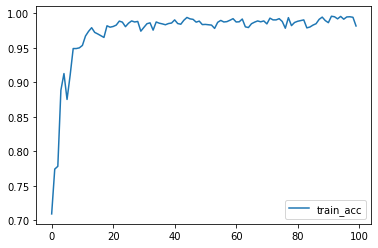

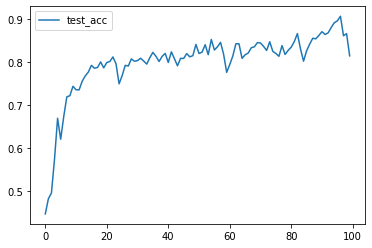

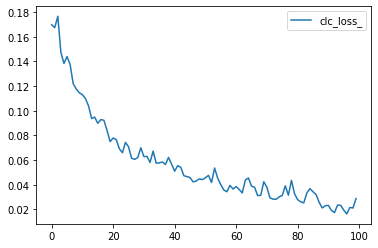

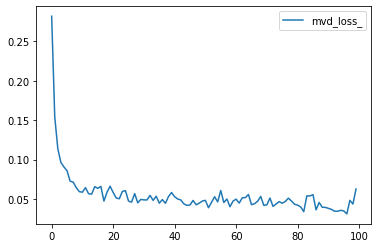

In [14]:
string=['train_acc','test_acc','clc_loss_','mvd_loss_'] 
for i in string: 
    path=r'C:\Users\帅哥泉\Desktop\VDR\CWRU-JNU\1'
    if os.path.exists(path)==False: 
        os.makedirs(path) 
    path=(path+r'\VDR_Student_{s}.csv').format(s=i) 
    data=pd.DataFrame(np.array(eval(i))) 
    data.to_csv(path,index=False) 
    plt.plot(eval(i),label=i) 
    plt.legend() 
    plt.show()